# Whisper Logit Lens and Attention Pattern Analysis

Exploring Whisper's internal representations using:
1. **Encoder Lens**: Project encoder representations through decoder
2. **Decoder Logit Lens**: Project decoder layers to vocabulary
3. **Attention Patterns**: Visualize self-attention and cross-attention
4. **Activation Patching**: Measure causal importance of layers

In [28]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import io
from dataclasses import dataclass

from transformers import WhisperForConditionalGeneration, WhisperProcessor
import datasets as ds

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: mps


In [29]:
# Load Whisper with eager attention (required for attention output)
model_name = 'openai/whisper-tiny'
model = WhisperForConditionalGeneration.from_pretrained(
    model_name,
    attn_implementation='eager',  # Required to get attention weights
).to(device)
processor = WhisperProcessor.from_pretrained(model_name)
model.eval()

print(f'Model: {model_name}')
print(f'Encoder layers: {model.config.encoder_layers}')
print(f'Decoder layers: {model.config.decoder_layers}')
print(f'Hidden dim: {model.config.d_model}')

Model: openai/whisper-tiny
Encoder layers: 4
Decoder layers: 4
Hidden dim: 384


In [30]:
# Load LibriSpeech - disable audio decoding to avoid torchcodec issues
N_LOAD = 60  # Load enough for analysis

dataset = ds.load_dataset(
    'librispeech_asr',
    'clean', 
    split='validation',
    streaming=True,
).cast_column('audio', ds.Audio(decode=False))

raw_samples = list(dataset.take(N_LOAD))

# Decode with soundfile
samples = []
for raw in raw_samples:
    audio_bytes = raw['audio']['bytes']
    audio_array, sr = sf.read(io.BytesIO(audio_bytes))
    samples.append({
        'audio': {'array': audio_array, 'sampling_rate': sr},
        'text': raw['text'],
    })

print(f'Loaded {len(samples)} samples')
print(f'First 5:')
for i, s in enumerate(samples[:5]):
    print(f'  {i}: "{s["text"][:50]}..."')

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 60 samples
First 5:
  0: "HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLI..."
  1: "HE WOULD HAVE TO PAY HER THE MONEY WHICH SHE WOULD..."
  2: "HURSTWOOD WALKED THE FLOOR MENTALLY ARRANGING THE ..."
  3: "HE ALSO THOUGHT OF HIS MANAGERIAL POSITION..."
  4: "HOW WOULD THE PAPERS TALK ABOUT IT..."


In [31]:
def process_audio(sample):
    """Process audio to Whisper input features."""
    audio = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        audio = resampler(torch.from_numpy(audio).float()).numpy()
    inputs = processor(audio, sampling_rate=16000, return_tensors='pt')
    return inputs.input_features.to(device)

# Process first sample
input_features = process_audio(samples[0])
ground_truth = samples[0]['text']
print(f'Input shape: {input_features.shape}')
print(f'Ground truth: "{ground_truth}"')

Input shape: torch.Size([1, 80, 3000])
Ground truth: "HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE"


In [32]:
# Generate transcription and get encoder outputs
with torch.no_grad():
    generated = model.generate(input_features, max_new_tokens=128)
    encoder_outputs = model.model.encoder(
        input_features,
        output_hidden_states=True,
        output_attentions=True,
        return_dict=True,
    )

generated_text = processor.batch_decode(generated, skip_special_tokens=True)[0]
print(f'Generated: "{generated_text}"')
print(f'Ground truth: "{ground_truth}"')

Generated: " He was in a fevered state of mind, owing to the blight his wife's action threatened to cast upon his entire future."
Ground truth: "HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE"


## 1. Encoder Self-Attention Analysis

Analyzing attention patterns across multiple samples to identify **head specialization**:
- **Local heads**: Attend to nearby positions (diagonal pattern)
- **Broadcast heads**: Uniform attention to specific positions (vertical stripes)
- **Energy-correlated heads**: Attend preferentially to speech vs silence

Key metrics:
- **Locality score**: How close to diagonal (1=local, 0.5=spread)
- **Uniformity score**: Entropy of attention distribution (1=uniform broadcast)
- **Energy correlation**: Correlation between attention received and mel energy (+speech, -silence)

In [33]:
# Encoder self-attention analysis across multiple samples
# Whisper encoder: 3000 mel frames -> 1500 positions (2x downsampling from conv layers)
# 3000 mel frames = 30 seconds, so 1500 positions = 30 seconds
# Each position = 20ms

N_SAMPLES = 50  # Number of samples to analyze
MS_PER_POSITION = 20  # Time resolution

print(f"Analyzing encoder attention across {N_SAMPLES} samples...")
print(f"Time resolution: {MS_PER_POSITION}ms per position")

# Collect attention patterns and mel energies from multiple samples
all_attention_patterns = []
all_mel_energies = []
sample_lengths = []

for i, sample in enumerate(samples[:N_SAMPLES]):
    if i % 10 == 0:
        print(f"  Processing sample {i+1}/{N_SAMPLES}...")
    
    input_feats = process_audio(sample)
    
    with torch.no_grad():
        enc_out = model.model.encoder(
            input_feats,
            output_attentions=True,
            return_dict=True,
        )
    
    # Stack attention from all layers: [4, 6, 1500, 1500]
    attn_stack = torch.stack([a[0] for a in enc_out.attentions])
    all_attention_patterns.append(attn_stack.cpu())
    
    # Get mel energy per position
    mel_energy = input_feats[0].mean(dim=0).cpu().numpy()  # [3000]
    mel_energy_down = mel_energy.reshape(1500, 2).mean(axis=1)  # [1500]
    all_mel_energies.append(mel_energy_down)
    sample_lengths.append(len(sample['audio']['array']) / sample['audio']['sampling_rate'])

# Compute mean attention pattern
mean_attn = torch.stack(all_attention_patterns).mean(dim=0)  # [4, 6, 1500, 1500]
n_layers, n_heads = mean_attn.shape[0], mean_attn.shape[1]
seq_len = mean_attn.shape[2]

print(f"\nMean attention shape: {mean_attn.shape}")
print(f"Sample durations: {np.mean(sample_lengths):.1f}s ± {np.std(sample_lengths):.1f}s")

Analyzing encoder attention across 50 samples...
Time resolution: 20ms per position
  Processing sample 1/50...
  Processing sample 11/50...
  Processing sample 21/50...
  Processing sample 31/50...
  Processing sample 41/50...

Mean attention shape: torch.Size([4, 6, 1500, 1500])
Sample durations: 4.6s ± 1.9s


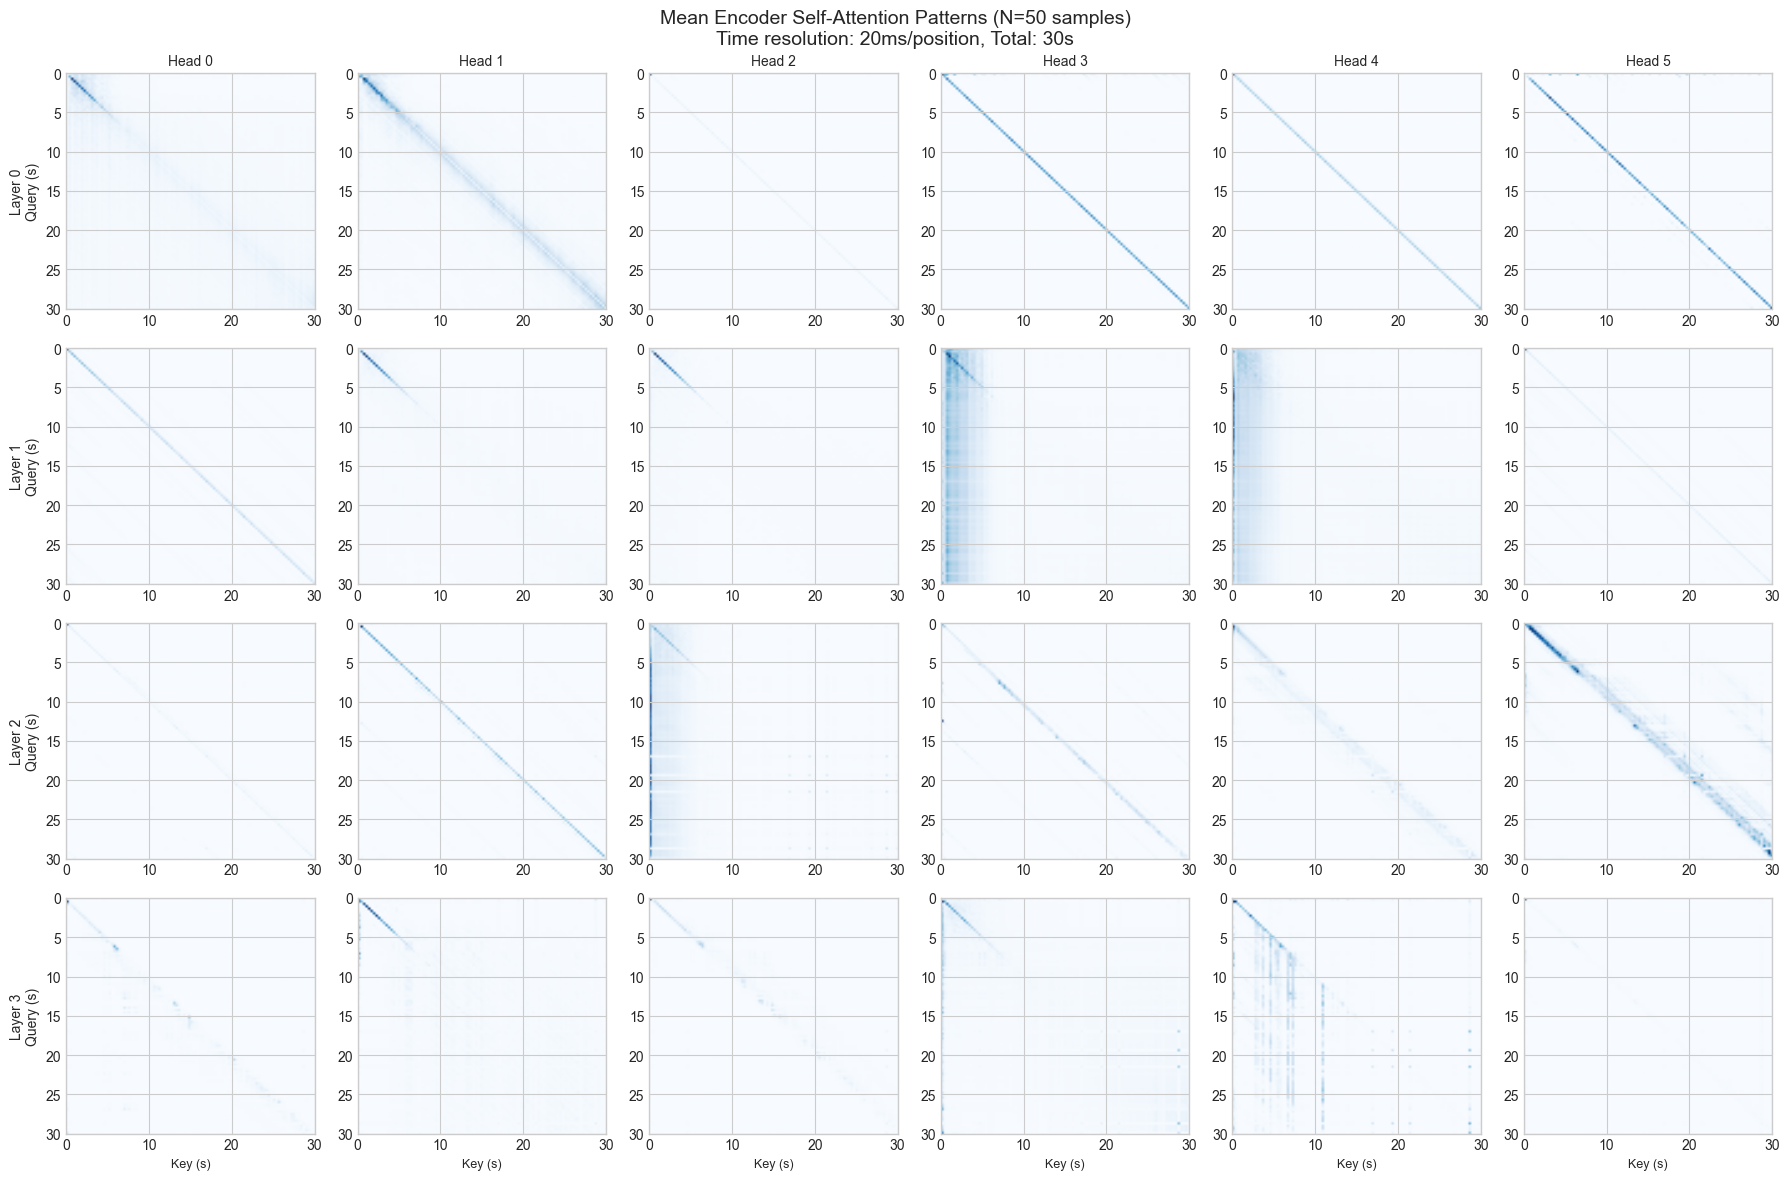

In [ ]:
# Plot mean attention patterns (averaged over N samples)
step = 15  # Subsample for visualization
time_extent = seq_len * MS_PER_POSITION / 1000  # Total time in seconds

fig, axes = plt.subplots(n_layers, n_heads, figsize=(18, 12))
fig.suptitle(f'Mean Encoder Self-Attention Patterns (N={N_SAMPLES} samples)\n'
             f'Time resolution: {MS_PER_POSITION}ms/position, Total: {time_extent:.0f}s', fontsize=14)

for l in range(n_layers):
    for h in range(n_heads):
        ax = axes[l, h]
        attn_sub = mean_attn[l, h, ::step, ::step].numpy()
        
        im = ax.imshow(attn_sub, cmap='Blues', aspect='auto',
                       extent=[0, time_extent, time_extent, 0],
                       interpolation='bilinear')  # Smooth out pixel grid
        
        if l == 0:
            ax.set_title(f'Head {h}', fontsize=10)
        if h == 0:
            ax.set_ylabel(f'Layer {l}\nQuery (s)', fontsize=10)
        if l == n_layers - 1:
            ax.set_xlabel('Key (s)', fontsize=9)
        
        # Only show ticks on edges
        # if l != n_layers - 1:
        ax.set_xticks([])
        # if h != 0:
        ax.set_yticks([])

    # ax.tick_params(
    #     axis='both',
    #     which='both',
    #     bottom=False,
    #     top=False,
    #     left=False,
    #     right=False,
    #     labelbottom=False,
    #     labelleft=False,
    # )


plt.tight_layout()
plt.show()

Computing attention-energy correlations for each head...


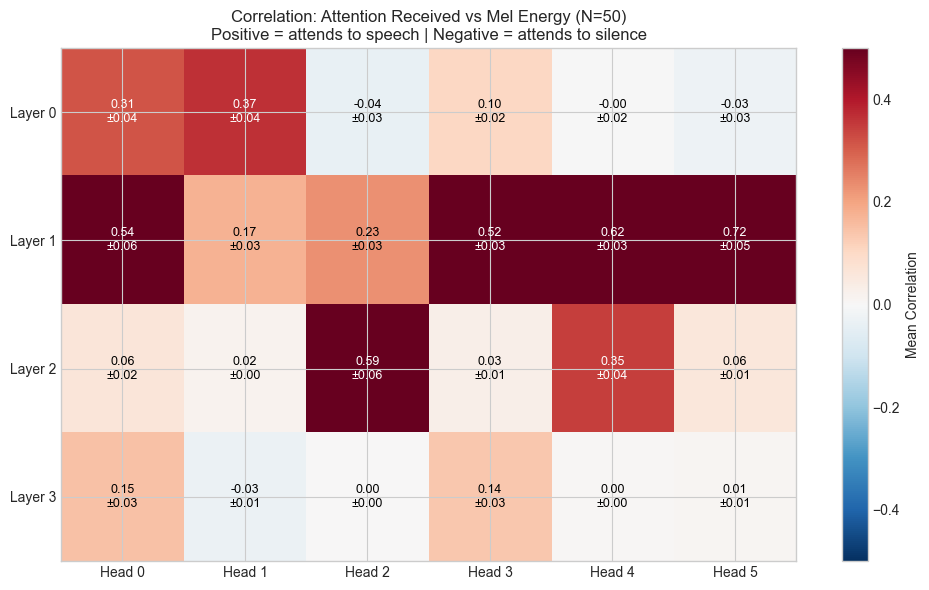


Most correlated heads (attend to speech):
  L1H5: r=0.722 ± 0.046
  L1H4: r=0.618 ± 0.033
  L2H2: r=0.595 ± 0.058

Most anti-correlated heads (attend to silence/pauses):
  L0H2: r=-0.036 ± 0.029
  L3H1: r=-0.030 ± 0.015
  L0H5: r=-0.026 ± 0.027


In [34]:
# Analyze correlation between attention received and mel energy for each head
# This reveals which heads attend to silence vs speech

print("Computing attention-energy correlations for each head...")

# For each sample, compute correlation between "attention received" (column sums) and mel energy
correlations = np.zeros((N_SAMPLES, n_layers, n_heads))

for i in range(N_SAMPLES):
    attn = all_attention_patterns[i]  # [4, 6, 1500, 1500]
    mel_energy = all_mel_energies[i]  # [1500]
    
    for l in range(n_layers):
        for h in range(n_heads):
            # Attention received = how much each position is attended TO (column sum)
            attn_received = attn[l, h].sum(dim=0).numpy()  # [1500]
            corr = np.corrcoef(attn_received, mel_energy)[0, 1]
            correlations[i, l, h] = corr if not np.isnan(corr) else 0

# Compute mean and std across samples
mean_corr = correlations.mean(axis=0)  # [4, 6]
std_corr = correlations.std(axis=0)    # [4, 6]

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(mean_corr, cmap='RdBu_r', vmin=-0.5, vmax=0.5, aspect='auto')

for l in range(n_layers):
    for h in range(n_heads):
        text = f'{mean_corr[l, h]:.2f}\n±{std_corr[l, h]:.2f}'
        ax.text(h, l, text, ha='center', va='center', fontsize=9,
                color='white' if abs(mean_corr[l, h]) > 0.25 else 'black')

ax.set_xticks(range(n_heads))
ax.set_xticklabels([f'Head {h}' for h in range(n_heads)])
ax.set_yticks(range(n_layers))
ax.set_yticklabels([f'Layer {l}' for l in range(n_layers)])
ax.set_title(f'Correlation: Attention Received vs Mel Energy (N={N_SAMPLES})\n'
             'Positive = attends to speech | Negative = attends to silence', fontsize=12)
plt.colorbar(im, ax=ax, label='Mean Correlation')
plt.tight_layout()
plt.show()

# Find most interesting heads
print("\nMost correlated heads (attend to speech):")
for idx in np.argsort(mean_corr.flatten())[-3:][::-1]:
    l, h = divmod(idx, n_heads)
    print(f"  L{l}H{h}: r={mean_corr[l, h]:.3f} ± {std_corr[l, h]:.3f}")

print("\nMost anti-correlated heads (attend to silence/pauses):")
for idx in np.argsort(mean_corr.flatten())[:3]:
    l, h = divmod(idx, n_heads)
    print(f"  L{l}H{h}: r={mean_corr[l, h]:.3f} ± {std_corr[l, h]:.3f}")


In [ ]:
# Deep dive: Show attention received vs mel energy for most interesting head
# Pick the head with strongest (positive or negative) correlation

best_idx = np.argmax(np.abs(mean_corr))
best_l, best_h = divmod(best_idx, n_heads)
print(f"Most interesting head: L{best_l}H{best_h} (r={mean_corr[best_l, best_h]:.3f})")

# Show 3 individual examples side by side
fig, axes = plt.subplots(3, 3, figsize=(16, 10))

example_indices = [0, N_SAMPLES//3, 2*N_SAMPLES//3]  # Spread across samples

for row, sample_idx in enumerate(example_indices):
    attn = all_attention_patterns[sample_idx][best_l, best_h]  # [1500, 1500]
    mel_energy = all_mel_energies[sample_idx]
    attn_received = attn.sum(dim=0).numpy()
    
    time_axis = np.arange(seq_len) * MS_PER_POSITION / 1000
    
    # Column 1: Attention pattern
    ax1 = axes[row, 0]
    ax1.imshow(attn[::10, ::10].numpy(), cmap='Blues', aspect='auto',
               extent=[0, time_extent, time_extent, 0], interpolation='bilinear')
    ax1.set_title(f'Sample {sample_idx}: Attention Pattern' if row == 0 else '')
    ax1.set_ylabel(f'Sample {sample_idx}\nQuery (s)')
    if row == 2:
        ax1.set_xlabel('Key (s)')
    
    # Column 2: Attention received vs Mel energy
    ax2 = axes[row, 1]
    ax2.plot(time_axis, attn_received / attn_received.max(), label='Attn received', alpha=0.8)
    ax2.plot(time_axis, mel_energy / mel_energy.max(), label='Mel energy', alpha=0.8)
    ax2.set_xlim(0, time_extent)
    ax2.set_title(f'Attention Received vs Mel Energy' if row == 0 else '')
    if row == 0:
        ax2.legend(fontsize=8)
    if row == 2:
        ax2.set_xlabel('Time (s)')
    
    # Column 3: Scatter plot
    ax3 = axes[row, 2]
    ax3.scatter(mel_energy, attn_received, alpha=0.3, s=5)
    corr = correlations[sample_idx, best_l, best_h]
    ax3.set_title(f'Correlation: r={corr:.3f}' if row == 0 else f'r={corr:.3f}')
    if row == 2:
        ax3.set_xlabel('Mel Energy')
    ax3.set_ylabel('Attention Received')

fig.suptitle(f'L{best_l}H{best_h} Analysis: Attention Received vs Audio Energy', fontsize=14)
plt.tight_layout()
plt.show()

# Show histogram of correlations for this head
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(correlations[:, best_l, best_h], bins=20, edgecolor='black', alpha=0.7)
ax.axvline(mean_corr[best_l, best_h], color='red', linestyle='--', 
           label=f'Mean: {mean_corr[best_l, best_h]:.3f}')
ax.axvline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Correlation (attention received vs mel energy)')
ax.set_ylabel('Count')
ax.set_title(f'L{best_l}H{best_h}: Correlation Distribution (N={N_SAMPLES})')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Compute attention pattern metrics for head specialization analysis
print("Computing head specialization metrics...")

# Metrics across all samples
locality_scores = np.zeros((N_SAMPLES, n_layers, n_heads))  # How local is attention
uniformity_scores = np.zeros((N_SAMPLES, n_layers, n_heads))  # How uniform is attention
first_pos_bias = np.zeros((N_SAMPLES, n_layers, n_heads))  # BOS/first position attention

for i in range(N_SAMPLES):
    attn = all_attention_patterns[i]  # [4, 6, 1500, 1500]
    
    for l in range(n_layers):
        for h in range(n_heads):
            a = attn[l, h]  # [1500, 1500]
            
            # Locality: mean distance from diagonal weighted by attention
            positions = torch.arange(seq_len)
            query_pos = positions.unsqueeze(1)
            key_pos = positions.unsqueeze(0)
            distance = (key_pos - query_pos).abs().float()
            mean_distance = (a * distance).sum() / a.sum()
            # Normalize by max possible distance
            locality_scores[i, l, h] = 1 - (mean_distance / seq_len).item()
            
            # Uniformity: entropy of attention distribution (normalized)
            # High entropy = uniform, low entropy = peaked
            a_flat = a.mean(dim=0)  # Average attention over queries
            a_flat = a_flat / a_flat.sum()
            entropy = -(a_flat * (a_flat + 1e-10).log()).sum().item()
            max_entropy = np.log(seq_len)
            uniformity_scores[i, l, h] = entropy / max_entropy
            
            # First position bias
            first_pos_bias[i, l, h] = a[:, 0].mean().item()

# Average across samples
mean_locality = locality_scores.mean(axis=0)
mean_uniformity = uniformity_scores.mean(axis=0)
mean_first_bias = first_pos_bias.mean(axis=0)

# Plot head specialization summary
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Locality
im1 = axes[0].imshow(mean_locality, cmap='Reds', aspect='auto', vmin=0.5, vmax=1)
axes[0].set_title('Locality Score\n(1=diagonal, 0.5=spread)')
axes[0].set_xlabel('Head')
axes[0].set_ylabel('Layer')
for l in range(n_layers):
    for h in range(n_heads):
        axes[0].text(h, l, f'{mean_locality[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im1, ax=axes[0])

# Uniformity
im2 = axes[1].imshow(mean_uniformity, cmap='Greens', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Uniformity Score\n(1=uniform, 0=peaked)')
axes[1].set_xlabel('Head')
for l in range(n_layers):
    for h in range(n_heads):
        axes[1].text(h, l, f'{mean_uniformity[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im2, ax=axes[1])

# Energy correlation (from earlier)
im3 = axes[2].imshow(mean_corr, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
axes[2].set_title('Energy Correlation\n(+speech, -silence)')
axes[2].set_xlabel('Head')
for l in range(n_layers):
    for h in range(n_heads):
        axes[2].text(h, l, f'{mean_corr[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im3, ax=axes[2])

for ax in axes:
    ax.set_xticks(range(n_heads))
    ax.set_yticks(range(n_layers))

fig.suptitle(f'Encoder Head Specialization (N={N_SAMPLES} samples)', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("HEAD SPECIALIZATION SUMMARY")
print("="*70)
for l in range(n_layers):
    for h in range(n_heads):
        loc = mean_locality[l, h]
        uni = mean_uniformity[l, h]
        corr = mean_corr[l, h]
        
        # Classify head type
        if loc > 0.85:
            pattern = "LOCAL (diagonal)"
        elif uni > 0.8:
            pattern = "UNIFORM (broadcast)"
        elif abs(corr) > 0.2:
            pattern = f"ENERGY-{'SPEECH' if corr > 0 else 'SILENCE'}"
        else:
            pattern = "MIXED"
        
        print(f"L{l}H{h}: {pattern:20s} | loc={loc:.2f}, uni={uni:.2f}, corr={corr:+.2f}")


## 2. Encoder Layer Representation Similarity

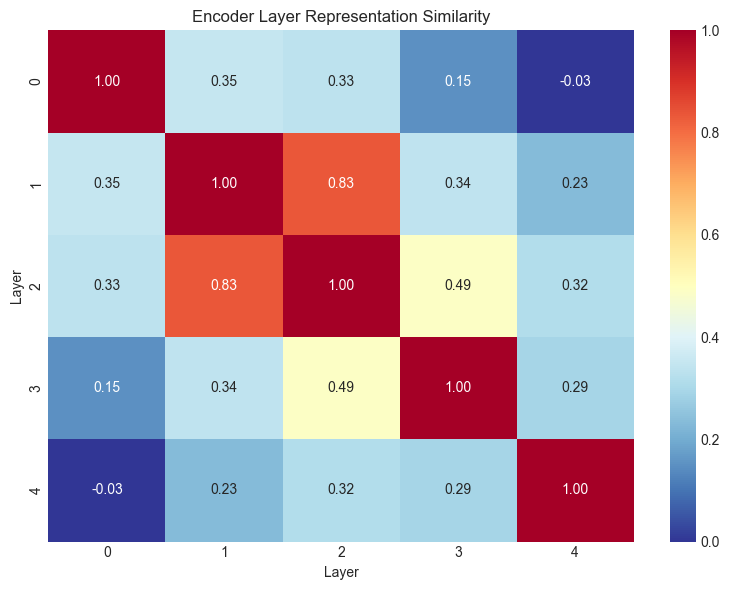

In [9]:
# Compute cosine similarity between layers
hidden_states = encoder_outputs.hidden_states
n_layers = len(hidden_states)

sims = np.zeros((n_layers, n_layers))
for i in range(n_layers):
    for j in range(n_layers):
        h_i = hidden_states[i][0].flatten()
        h_j = hidden_states[j][0].flatten()
        sims[i, j] = torch.nn.functional.cosine_similarity(h_i.unsqueeze(0), h_j.unsqueeze(0)).item()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(sims, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Layer')
ax.set_ylabel('Layer')
ax.set_title('Encoder Layer Representation Similarity')
plt.tight_layout()
plt.show()

## 3. Encoder Lens

Feed each encoder layer's output to the decoder to see when transcription emerges.

In [12]:
# Cross-attention: Simple grid view
# Shows which audio frames each output token attends to

n_cross_layers = len(cross_attentions)
n_cross_heads = cross_attentions[0].shape[1]

print(f"Cross-attention: {n_cross_layers} layers, {n_cross_heads} heads")
print(f"Shape per layer: {cross_attentions[0].shape} (batch, heads, dec_len, enc_len)")

# Simple grid plot
fig, axes = plt.subplots(n_cross_layers, n_cross_heads, figsize=(18, 12))
fig.suptitle('Cross-Attention Patterns (Decoder tokens → Encoder frames)', fontsize=14)

for l in range(n_cross_layers):
    for h in range(n_cross_heads):
        ax = axes[l, h]
        attn = cross_attentions[l][0, h].cpu().numpy()
        
        # Subsample encoder dim for display
        enc_step = max(1, attn.shape[1] // 100)
        attn_sub = attn[:, ::enc_step]
        
        ax.imshow(attn_sub, cmap='Purples', aspect='auto', interpolation='bilinear')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if l == 0:
            ax.set_title(f'Head {h}', fontsize=10)
        if h == 0:
            ax.set_ylabel(f'Layer {l}', fontsize=10)

plt.tight_layout()
plt.show()

NameError: name 'cross_attentions' is not defined

## 4. Cross-Attention Analysis

In [ ]:
# Get cross-attention from decoder
with torch.no_grad():
    decoder_outputs = model.model.decoder(
        input_ids=generated,
        encoder_hidden_states=encoder_outputs.last_hidden_state,
        output_attentions=True,
        return_dict=True,
    )

cross_attentions = decoder_outputs.cross_attentions
tokens = processor.batch_decode(generated[0], skip_special_tokens=False)

print(f'Cross attention layers: {len(cross_attentions)}')
print(f'Tokens: {tokens[:10]}...')

In [ ]:
# Plot cross-attention for last layer
layer_idx = -1
attn = cross_attentions[layer_idx][0]  # [heads, dec_len, enc_len]
mean_attn = attn.mean(dim=0).cpu().numpy()  # [dec_len, enc_len]

# Truncate for visualization
max_tokens = min(30, mean_attn.shape[0])
display_attn = mean_attn[:max_tokens]
display_tokens = [t.replace(' ', '_') for t in tokens[:max_tokens]]

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(display_attn, cmap='Blues', ax=ax, xticklabels=50)
ax.set_yticks(range(len(display_tokens)))
ax.set_yticklabels(display_tokens, fontsize=8)
ax.set_xlabel('Encoder Position (Audio Frame)')
ax.set_ylabel('Decoder Token')
ax.set_title('Cross-Attention (Last Layer, Mean over Heads)')
plt.tight_layout()
plt.show()

## 5. Activation Patching - Causal Importance

In [ ]:
from jiwer import wer

def patch_encoder_layer(model, input_features, layer_idx):
    """Zero out one encoder layer and measure effect."""
    def patch_hook(module, input, output):
        if isinstance(output, tuple):
            return (torch.zeros_like(output[0]),) + output[1:]
        return torch.zeros_like(output)
    
    handle = model.model.encoder.layers[layer_idx].register_forward_hook(patch_hook)
    try:
        with torch.no_grad():
            gen = model.generate(input_features, max_new_tokens=128)
        return processor.batch_decode(gen, skip_special_tokens=True)[0]
    finally:
        handle.remove()

print('Activation Patching Results')
print('=' * 60)
print(f'Original: "{generated_text}"')
print()

original_wer = wer(ground_truth.lower(), generated_text.lower())
patching_results = []

for layer_idx in range(model.config.encoder_layers):
    patched_text = patch_encoder_layer(model, input_features, layer_idx)
    patched_wer = wer(ground_truth.lower(), patched_text.lower())
    wer_delta = patched_wer - original_wer
    
    patching_results.append({'layer': layer_idx, 'wer': patched_wer, 'delta': wer_delta})
    print(f'Layer {layer_idx} zeroed: WER={patched_wer:.2f} (delta={wer_delta:+.2f})')
    print(f'  "{patched_text[:60]}..."')

In [ ]:
# Plot causal importance
layers = [r['layer'] for r in patching_results]
deltas = [r['delta'] for r in patching_results]

fig, ax = plt.subplots(figsize=(10, 4))
colors = ['red' if d > 0 else 'green' for d in deltas]
ax.bar(layers, deltas, color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Encoder Layer')
ax.set_ylabel('WER Increase When Zeroed')
ax.set_title('Causal Importance of Encoder Layers')
ax.set_xticks(layers)
plt.tight_layout()
plt.show()

## Summary

Key findings:
1. **Encoder Lens**: Shows at which layer meaningful transcription emerges
2. **Cross-Attention**: Shows which audio frames matter for each token
3. **Activation Patching**: Shows which layers are causally important